In [2]:
%load_ext autoreload
%autoreload 2

import IPython.display

import collections
import imageio
import itertools
import os
import sys
import typing

import numpy as np
import PIL
import torch
import torchsummary
import torchvision
from tqdm.auto import tqdm

import matplotlib.animation as animation
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../models'))
from CycleGAN.model import initialize_weights, Generator, Discriminator, ResNetBlock

# Config

In [3]:
# dataloader params
IMAGE_SIZE: int = 256
BATCH_SIZE: int = 1

# loss components' weights
LAMBDA_CYCLE: float = 10.
LAMBDA_IDENTITY: float = 0.5 * LAMBDA_CYCLE

# hyperparameter of Adam
BETA_1: float = 0.5  
LEARNING_RATE: float = 0.0002

# whether to train discriminator more often
D_TO_G_STEPS_RATIO: int = 1
    
FAKE_LABEL: int = 0
REAL_LABEL: int = 1

DEVICE = torch.device('cuda:7')

# Data loading

In [4]:
transforms = torchvision.transforms.Compose(
    (
        torchvision.transforms.Resize(IMAGE_SIZE),
        torchvision.transforms.CenterCrop(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
    )
)

folder_A = torchvision.datasets.ImageFolder(
    '../data/processed/CycleGAN/paintings/',
    transform=transforms
)

loader_A = torch.utils.data.DataLoader(
    folder_A, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

folder_B = torchvision.datasets.ImageFolder(
    '../data/processed/CycleGAN/photos/',
    transform=transforms
)

loader_B = torch.utils.data.DataLoader(
    folder_B, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

# DCGAN

## Generator

In [5]:
G_A = Generator().to(DEVICE)
G_A.apply(initialize_weights)

G_B = Generator().to(DEVICE)
G_B.apply(initialize_weights)

optimizer_G = torch.optim.Adam(
    itertools.chain(G_A.parameters(), G_B.parameters()),
    lr=LEARNING_RATE, 
    betas=(BETA_1, 0.999)
)

In [9]:
G_A.load_state_dict(torch.load('./G_A.pth'))
G_B.load_state_dict(torch.load('./G_B.pth'))

<All keys matched successfully>

## Discriminator

In [6]:
D_A = Discriminator().to(DEVICE)
D_A.apply(initialize_weights)


D_B = Discriminator().to(DEVICE)
D_B.apply(initialize_weights)

optimizer_D = torch.optim.Adam(
    itertools.chain(D_A.parameters(), D_B.parameters()), 
    lr=LEARNING_RATE,
    betas=(BETA_1, 0.999)
)

In [10]:
D_A.load_state_dict(torch.load('./D_A.pth'))
D_B.load_state_dict(torch.load('./D_B.pth'))

<All keys matched successfully>

## Criterions

In [6]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

## Training loop

In [7]:
def set_requires_grad(nets: typing.Iterable[torch.nn.Module], value: bool) -> None:
    for net in nets:
        for param in net.parameters():
            param.requires_grad = value

In [8]:
def create_label_vector(size: torch.Size, label: int) -> torch.Tensor:
    return torch.full(size, label, dtype=torch.float32, device=DEVICE)

In [9]:
num_epochs = 100

img_list = []
G_losses = []
D_losses = []
iter_counter = 0

for epoch in tqdm(range(num_epochs), desc='epoch'):
    iter_counter = 0
    for batch_A, batch_B in tqdm(zip(loader_A, loader_B), desc='batch'):
        iter_counter += 1
        
        real_A = batch_A[0].to(DEVICE) 
        real_B = batch_B[0].to(DEVICE)
        
        same_A = G_A(real_A)
        same_B = G_B(real_B)
        
        identity_loss = LAMBDA_IDENTITY * (
            criterion_identity(real_A, same_A) 
            + criterion_identity(real_B, same_B)
        )
        
        fake_A = G_A(real_B)
        cycled_B = G_B(fake_A)
        
        fake_B = G_B(real_A)
        cycled_A = G_A(fake_B)
        
        cycle_loss = LAMBDA_CYCLE * (
             criterion_cycle(real_A, cycled_A)
            + criterion_cycle(real_B, cycled_B)
        )        
        
        set_requires_grad([D_A, D_B], False)
        optimizer_G.zero_grad()
        
        disc_fake_A = D_A(fake_A)
        disc_fake_B = D_B(fake_B)
        
        gen_loss_A = criterion_GAN(
            disc_fake_A, create_label_vector(disc_fake_A.size(), REAL_LABEL)
        )
        gen_loss_B = criterion_GAN(
            disc_fake_B, create_label_vector(disc_fake_B.size(), REAL_LABEL)
        )
                
        loss_G = gen_loss_A + gen_loss_B + cycle_loss + identity_loss
        loss_G.backward()
        optimizer_G.step()
        G_losses.append(loss_G.detach().cpu().item())
        
        set_requires_grad([D_A, D_B], True)
        optimizer_D.zero_grad()
        
        disc_real_A = D_A(real_A)
        disc_real_B = D_B(real_B)
        
        disc_fake_A = D_A(fake_A.detach())
        disc_fake_B = D_B(fake_B.detach())
        
        disc_loss_A = 0.5 * (
            criterion_GAN(
                disc_real_A, create_label_vector(disc_real_A.size(), REAL_LABEL)
            )
            + criterion_GAN(
                disc_fake_A, create_label_vector(disc_fake_A.size(), FAKE_LABEL)
            ) 
        )
        disc_loss_A.backward()
        
        disc_loss_B = 0.5 * (
            criterion_GAN(
                disc_real_B, create_label_vector(disc_real_B.size(), REAL_LABEL)
            )
            + criterion_GAN(
                disc_fake_B, create_label_vector(disc_fake_B.size(), FAKE_LABEL)
            ) 
        )
        disc_loss_B.backward()        
        optimizer_D.step()
        D_losses.append((disc_loss_A + disc_loss_B).detach().cpu().item())
    
    print(
        f'Epoch {epoch}:\n'
        f'\t- loss_G: {np.mean(G_losses[-iter_counter:])}\n'
        f'\t- loss_D: {np.mean(D_losses[-iter_counter:])}'
    )

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

batch: |          | 0/? [00:00<?, ?it/s]

Epoch 0:
	- loss_G: 11.090516402358897
	- loss_D: 0.5316779291398867


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 1:
	- loss_G: 10.91655971920281
	- loss_D: 0.38978618229004114


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 10:
	- loss_G: 10.344492165665878
	- loss_D: 0.36826700796182565


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 11:
	- loss_G: 10.186769816959114
	- loss_D: 0.3811123859169975


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 19:
	- loss_G: 10.417539608757398
	- loss_D: 0.3068674404571672


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 20:
	- loss_G: 10.129189653354778
	- loss_D: 0.35990420538027995


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 30:
	- loss_G: 10.181098409214911
	- loss_D: 0.3398827228542657


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 32:
	- loss_G: 10.208001171287737
	- loss_D: 0.3317513466534907


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 40:
	- loss_G: 10.322948973429831
	- loss_D: 0.2650496931447054


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 41:
	- loss_G: 10.277315839340812
	- loss_D: 0.27267944137429634


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 50:
	- loss_G: 10.239140233798334
	- loss_D: 0.26669851066653577


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 51:
	- loss_G: 10.193927221130906
	- loss_D: 0.27489414243082033


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 61:
	- loss_G: 10.217940305060113
	- loss_D: 0.27687912828109246


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 62:
	- loss_G: 10.240308305673432
	- loss_D: 0.27140431183428443


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 71:
	- loss_G: 10.273009789617438
	- loss_D: 0.23205080103368786


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 72:
	- loss_G: 10.26385810221845
	- loss_D: 0.24014936125570396


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 73:
	- loss_G: 10.344013901481851
	- loss_D: 0.2458099006315726


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 75:
	- loss_G: 10.382334884844328
	- loss_D: 0.22328190074972154


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 76:
	- loss_G: 10.54866470474946
	- loss_D: 0.19658215674816779


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 85:
	- loss_G: 10.1633400659115
	- loss_D: 0.2496159673581303


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 86:
	- loss_G: 10.266676666792373
	- loss_D: 0.2571000038123314


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 94:
	- loss_G: 10.498800297578176
	- loss_D: 0.2342067484346311


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 95:
	- loss_G: 10.168715218354388
	- loss_D: 0.282074102369404


batch: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 96:
	- loss_G: 10.147673634409207
	- loss_D: 0.25856199012306785


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 97:
	- loss_G: 10.170100199548822
	- loss_D: 0.27193903094920063


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 98:
	- loss_G: 10.178115645173
	- loss_D: 0.26479960132352137


batch: |          | 0/? [00:00<?, ?it/s]

Epoch 99:
	- loss_G: 10.104988100235921
	- loss_D: 0.28234279117606886


Process Process-784:
Process Process-767:
Process Process-736:
Process Process-744:
Process Process-688:
Process Process-783:
Process Process-776:
Process Process-781:
Process Process-734:
Process Process-686:
Process Process-685:
Process Process-733:
Traceback (most recent call last):
Process Process-656:
Process Process-800:
Process Process-584:
Process Process-534:
Process Process-735:
Process Process-663:
Process Process-576:
Process Process-648:
Process Process-488:
Process Process-687:
Process Process-768:
Process Process-472:
Process Process-496:
Process Process-424:
Process Process-328:
Process Process-696:
Process Process-440:
Process Process-520:
Process Process-608:
Process Process-456:
Process Process-782:
Process Process-552:
Process Process-712:
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Process Process-320:
Tracebac

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 36

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
Traceback (m

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
Traceback (most recent call last):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, 

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
Traceback (most recent call last):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in j

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in 

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
Traceback (most recent call last):
Process Process-352:
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_pai

Traceback (most recent call last):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
Process Process-600:
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join
    thread.join()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/mu

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/vvivanov/anaconda3/envs/i_am_somethi

  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/queues.py", line 201, in _finalize_join


KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
KeyboardInterrupt
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/vvivanov/anaconda3/envs/i_am_something_of_a_painter_myself/lib/python3.9/thr

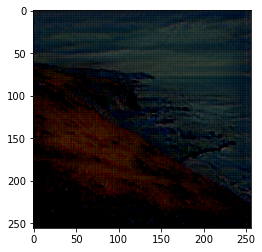

In [18]:
with torch.no_grad():
    plt.imshow(
        G_A(folder_B[8][0].to(DEVICE).unsqueeze(0))
        .cpu()
        .squeeze(0)
        .permute((1, 2, 0))
        .clip(0, 1)
    )

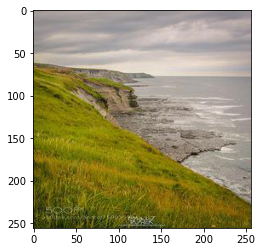

In [17]:
plt.imshow(
    folder_B[8][0]
        .cpu()
        .squeeze(0)
        .permute((1, 2, 0))
        .clip(0, 1)
)

In [14]:
torch.save(G_A.state_dict(), './G_A.pth')
torch.save(G_B.state_dict(), './G_B.pth')
torch.save(D_A.state_dict(), './D_A.pth')
torch.save(D_B.state_dict(), './D_B.pth')